In [1]:
from gptopt.optim.attn_kq import * 
from utils import *
from gptopt.optim.least_squares_torchmin import * 

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch

from gptopt.utils import set_seed
set_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Comparison of methods to solve
$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G_1, Z_1 \rangle + \langle G_2, Z_2 \rangle + h(X) \\ 
\text{subject to} & X = Z_1^\top B + A^\top Z_2
\end{array} 
$$

## PDHG
$$
\begin{aligned}
Y^{t+1} &= \operatorname{prox}_{\rho h^*}(Y^t + \rho 
((2Z_1^t - Z_1^{t-1})^\top B  + A^\top (2Z_2^t - Z_2^{t-1})))\\
\begin{bmatrix}
    Z_1^{t+1} \\ Z_2^{t+1}
\end{bmatrix} &=  \begin{bmatrix}
    Z_1^t \\ Z_2^t
\end{bmatrix} - \gamma \left (
\begin{bmatrix}
    B(Y^{t+1})^\top \\ AY^{t+1}
\end{bmatrix}
+ \begin{bmatrix}
    G_1 \\ G_2
\end{bmatrix} \right )  
\end{aligned}
$$


In [3]:
n_layer = 4
std1 = 0.02 / np.sqrt(2.0 * n_layer)
std2 = 0.01
rank_ratio = 0.7
max_iter = 1000

betas = [ 1e-3, 5e-4, 1e-4]

#  $m=50, ~n=10, ~h=5$

In [4]:
n_head = 5
m = 50
n = 10

In [ ]:
A2, A1, G1, G2 = gaussian_data_heads(m, n, n_head=n_head, std1=std1, std2=std2, 
                                            rank_ratio=rank_ratio, G_in_range=True)

beta = 0.05

A_linop = attn_linop_from_matrices_heads(A1, A2, n_head=n_head)
Grad = Z1_Z2_pack_Z_heads(G1, G2, n_head=n_head)
lamb_max = A_linop.fro_norm
mu_reg = 0 

print(f"{lamb_max=:.4e}")

lamb_max=2.2527e-01


In [6]:
Z_star, f_star, Y_star = cvxpy_A_linop_heads(Grad.cpu().numpy(), A_linop, beta, n_head=n_head)
Z_star_torch = torch.tensor(Z_star, dtype=A1.dtype, device=device)
Y_star_torch = torch.tensor(Y_star, dtype=A1.dtype, device=device)

In [7]:
# Torch prox for h* (uses prox_l1 from pdhg.py)
prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
h_conj = lambda y: beta * torch.abs(y).sum()

In [8]:
func_obj = lambda Z: (Grad * Z).sum().item()  
func_constr_viol = lambda Z: max(torch.max(torch.abs(A_linop.mv(Z))).item() - beta, 0) / beta

In [9]:
print(
    f"{f_star=:.4e}, "
    f"{func_obj(Z_star_torch)}, "
    f"\ncvxpy constraint violation: "
    f"{func_constr_viol(Z_star_torch)}"
) 

pd_residuals_max_ball_linop(A_linop, Y_star_torch, Z_star_torch, Grad, beta, mu_reg)

f_star=-2.4376e-02, -0.02437550267595882, 
cvxpy constraint violation: 0.0


(1.082938654108091e-07,
 9.686097784191293e-08,
 2.770966602070011e-19,
 1.518667826959098e-16)

In [10]:
residuals_cold_start = compare_methods_fast_pdhg(prox_h_conj, h_conj, A_linop, Grad, beta=beta, 
                                                 mu_reg=mu_reg, f_star=f_star, 
                            stopping=False, max_iter=max_iter, eps_abs=1e-5)

Y0, res_lsmr_y, itn_y = solve_lsmr_Y_lstsq(A_linop, Grad, n_head=n_head)
Z0, res_lsmr_z, itn_z = solve_lsmr_Z_lstsq(A_linop, beta, Y0, n_head=n_head)

print(f"{res_lsmr_y=:.4e}, {res_lsmr_z=:.4e}, {itn_y=}, {itn_z=}")
r1, r1_rel, r2, r2_rel = pd_residuals_max_ball_linop(A_linop, Y0, Z0, Grad, beta, mu_reg)
print(f"init {r1_rel=:.4e}, {r2_rel=:.4e}")   

residuals_warm_start = compare_methods_fast_pdhg(prox_h_conj, h_conj, A_linop, Grad, 
                                        Z0=Z0, Y0=Y0,
                                        beta=beta, mu_reg=mu_reg, f_star=f_star, stopping=False, max_iter=max_iter, eps_abs=1e-5)

Method                 Obj          Viol
----------------------------------------
pdhg          -1.433638e-02  1.179241e-03
rehpdhg       -1.434802e-02  7.163381e-04
pdhg ds       -2.304774e-02  1.360644e-03
rehpdhg ds    -2.031178e-02  3.852773e-03
ada rehpdhg   -1.365986e-02  2.750020e-06
ada rehpdhg ds  -1.669479e-02  1.934991e-04
res_lsmr_y=1.0586e-08, res_lsmr_z=1.1743e-08, itn_y=20, itn_z=20
init r1_rel=2.0000e+00, r2_rel=1.0586e-08
Method                 Obj          Viol
----------------------------------------
init          2.437550e-02  3.351625e-08
pdhg          1.241132e-02  2.775558e-16
rehpdhg       2.435584e-02  6.245415e-04
pdhg ds       -1.583561e-02  3.671462e-03
rehpdhg ds    2.430016e-02  1.874135e-03
ada rehpdhg   2.264463e-02  2.775558e-16
ada rehpdhg ds  1.874047e-02  1.719192e-05


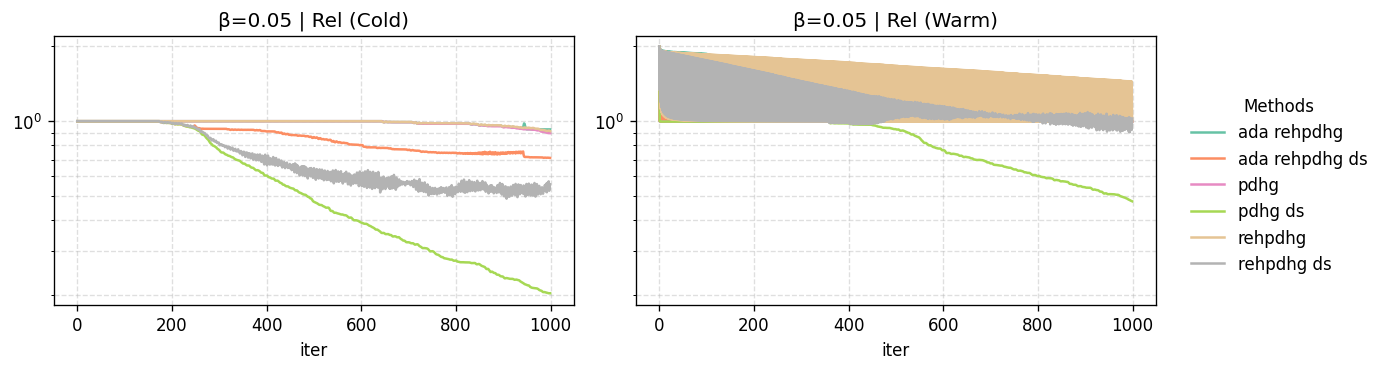

In [11]:
_ = plot_residuals_cold_warm_grid_by_param(
    {beta:residuals_cold_start},
    {beta:residuals_warm_start},
    param_name="beta", 
    dpi=120, 
)

#  $m=768, ~n=64, ~h=12$

In [12]:
m = 768
n_head = 12
n = 64 * n_head

In [13]:
std1 = 1
std2 = 1
beta = 0.05

A2, A1, G1, G2 = gaussian_data_heads(m, n, n_head=n_head, std1=std1, std2=std2, 
                                            rank_ratio=rank_ratio, G_in_range=True)

A_linop = attn_linop_from_matrices_heads(A1, A2, n_head=n_head)
Grad = Z1_Z2_pack_Z_heads(G1, G2, n_head=n_head)
lamb_max = A_linop.fro_norm

print(f"{lamb_max=:.4e}")

lamb_max=1.0868e+03


In [14]:
residuals_cold_start, residuals_warm_start = {}, {}
lsmr_maxiter = 200
for beta in betas:
    # Torch prox for h* (uses prox_l1 from pdhg.py)
    prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
    h_conj = lambda y: beta * torch.abs(y).sum()

    mu_reg = 0
    print(f"{beta=}, {lamb_max=:.4e}") 
    residuals_cold_start[beta] = compare_methods_fast_pdhg(prox_h_conj, h_conj, A_linop, Grad, beta=beta, 
                                                 mu_reg=mu_reg, f_star=None, 
                            stopping=False, max_iter=max_iter, eps_abs=1e-5)

    Y0, res_lsmr_y, itn_y = solve_lsmr_Y_lstsq(A_linop, Grad, maxiter=lsmr_maxiter, n_head=n_head)
    Z0, res_lsmr_z, itn_z = solve_lsmr_Z_lstsq(A_linop, beta, Y0, maxiter=lsmr_maxiter, n_head=n_head)

    print(f"{res_lsmr_y=:.4e}, {res_lsmr_z=:.4e}, {itn_y=}, {itn_z=}")
    r1, r1_rel, r2, r2_rel = pd_residuals_max_ball_linop(A_linop, Y0, Z0, Grad, beta, mu_reg)
    print(f"init {r1_rel=:.4e}, {r2_rel=:.4e}") 

    residuals_warm_start[beta] = compare_methods_fast_pdhg(prox_h_conj, h_conj, A_linop, Grad, 
                                        Z0=Z0, Y0=Y0,
                                        beta=beta, mu_reg=mu_reg, f_star=None, stopping=False, max_iter=max_iter, eps_abs=1e-5)

beta=0.001, lamb_max=1.0868e+03
Method                 Obj          Viol
----------------------------------------
pdhg          -2.653224e+01  1.514721e+01
rehpdhg       -1.944770e+01  4.737054e+00
pdhg ds       -4.664701e+01  2.724045e+01
rehpdhg ds    -2.085023e+01  5.331705e+00
ada rehpdhg   -9.142160e+00  2.247846e+00
ada rehpdhg ds  -9.192573e+00  1.767153e+00
res_lsmr_y=1.3893e-04, res_lsmr_z=6.3410e-03, itn_y=200, itn_z=200
init r1_rel=1.9999e+00, r2_rel=1.3893e-04
Method                 Obj          Viol
----------------------------------------
init          9.211238e+00  5.616148e-02
pdhg          -9.218216e+00  4.189482e+00
rehpdhg       -9.209069e+00  3.739164e-01
pdhg ds       -9.226077e+00  4.032576e+00
rehpdhg ds    -9.211842e+00  2.758153e-01
ada rehpdhg   -9.234472e+00  5.935425e-01
ada rehpdhg ds  -9.228121e+00  4.995919e-01
beta=0.0005, lamb_max=1.0868e+03
Method                 Obj          Viol
----------------------------------------
pdhg          -2.653224e+01  3.

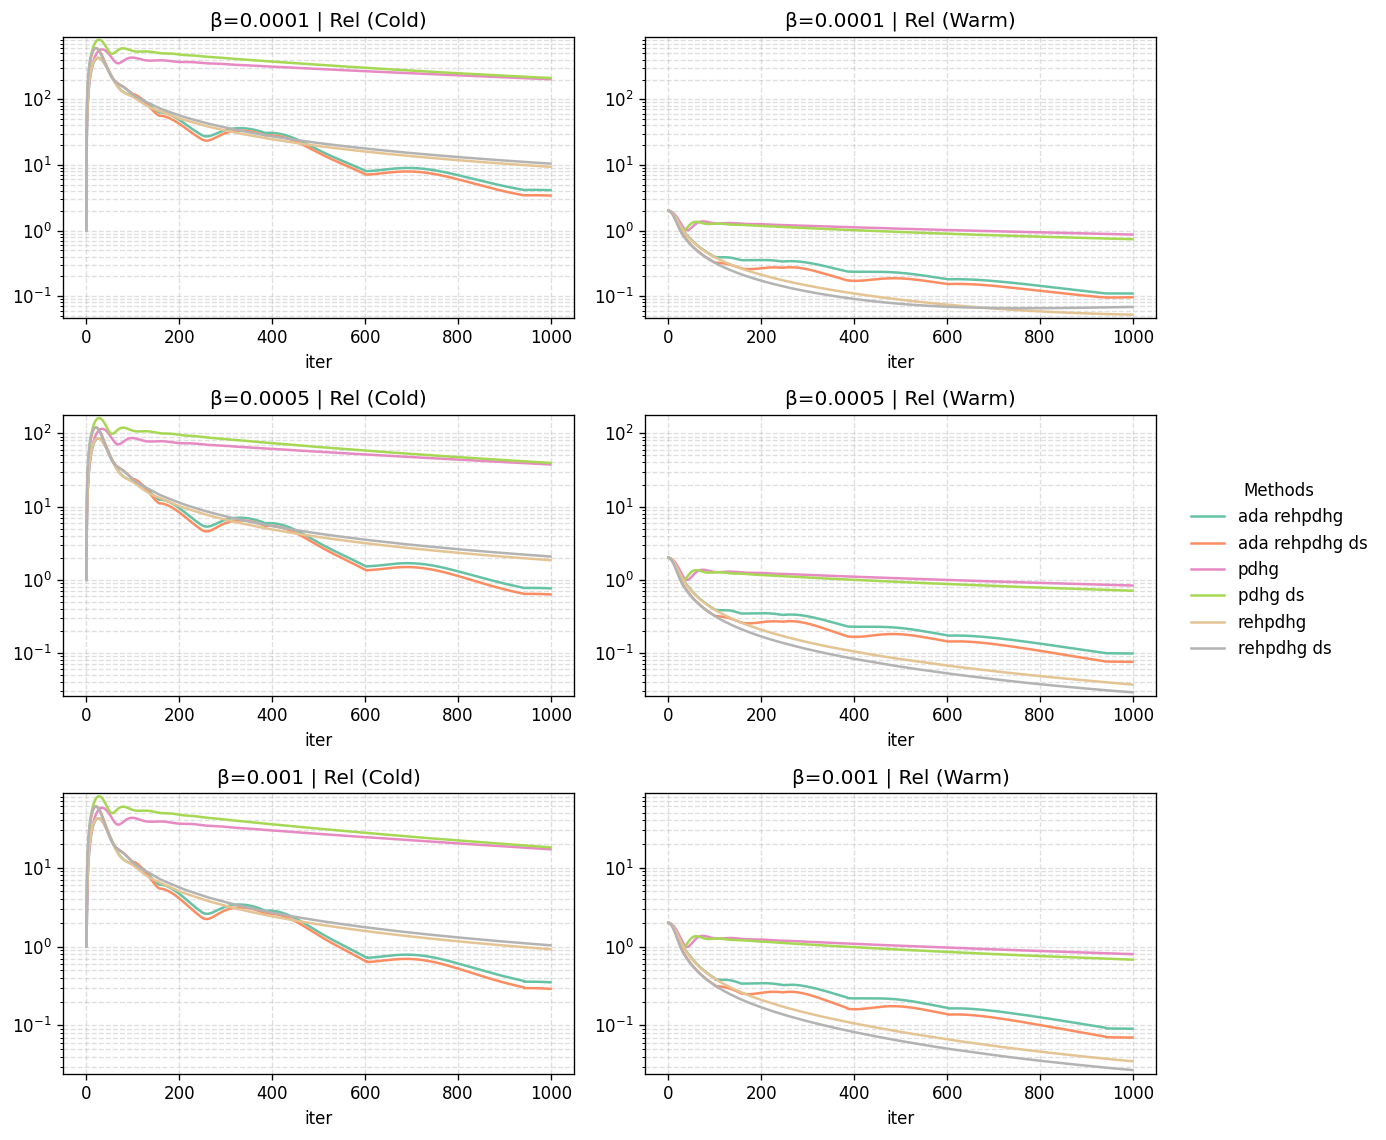

In [15]:
_ = plot_residuals_cold_warm_grid_by_param(
    residuals_cold_start,
    residuals_warm_start,
    param_name="beta", 
    dpi=120, 
)